# **CC6204 - Deep Learning**

## Alumno: Felipe Morales

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.utils import shuffle

#Packages to use pytorch
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import sys

#We explicitly set the random seed in order to get the same results in each run
SEED = 8

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability 
*   delayed healing 
*   partial paresis 
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\]. 

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2022-09-21 01:05:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: ‘diabetes_data_upload.csv’

diabetes_data_uploa 100%[===================>]  33.87K  --.-KB/s    in 0.07s   

2022-09-21 01:05:15 (495 KB/s) - ‘diabetes_data_upload.csv’ saved [34682/34682]



In [3]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [4]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [5]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [6]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


In [7]:
#Pack data with labels
train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))
print(len(train_data))
print(len(test_data))

415
104


In [8]:
#Split train data into TRAIN + VALIDATION (10% of the data as validation)
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [9]:
#Pytorch has a nice feature to prepare data. The DataLoader creates an iterator of batches which are very convenient for training
#Set the batch size the biggest value as possible depending on your GPU. Operations in a batch are parallelized.
BATCH_SIZE = 20

train_iterator = data.DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20. 
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

16 x 16 -> 16 x 8 -> 8 x 1

In [10]:
#Class for our neural network. When a class inherits from torch.nn.Module, 
#it automatically becomes a neural network

class MLP(nn.Module):
  # We need to define two methods at leats: constructor and forward

  #Constructor is for member definitions
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.fc1 = nn.Linear(input_dim, 16)
    self.fc2 = nn.Linear(16, 8)
    self.fc3 = nn.Linear(8, output_dim)

  #Forward: what happens when we feed the network with data
  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.relu(self.fc1(input))
    h_2 = F.relu(self.fc2(h_1))
    #y_pred = F.sigmoid(self.fc3(h_2))
    y_pred = self.fc3(h_2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred, h_2

In [11]:
# Create the model
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [12]:
#Create the object for the optimization. 
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [13]:
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

In [16]:
#Function to compute the accuracy. We assume the predictions and the labels are tensors in the GPU

def calculate_accuracy(y_pred, y):
  #top_pred = y_pred.argmax(1) #keepDim=True
  #correct = top_pred.eq(y.view_as(top_pred)).sum()
  #acc = correct.float()/y.shape[0]
  test_output = (y_pred >= 0.5)
  correct = (test_output == y).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [17]:
#Define a function to perform training

def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()

  #Training loop
  for (x, y) in iterator:
    #x= x.float()
    #y = y.float()
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients

    y_pred, _ = model(x) #Feed the network with data

    loss = criterion(y_pred.float(), y.float()) #Compute the loss

    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
    
    loss.backward() #Compute gradients
    
    optimizer.step() #Apply update rules  
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
#Function to test neural network

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)
      
      y_pred, _ = model(x.float()) # .-.-.float()
      
      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
#Let's perform the training

EPOCHS = 2000

best_valid_loss = float('inf')

train_loss_list_p1 = []
test_loss_list_p1 = []

for epoch in range(EPOCHS):

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

  train_loss_list_p1.append(float(train_loss))
  test_loss_list_p1.append(float(test_loss))
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')

    
  sys.stdout.write('\rEpoch {}, Train loss: {:.3f} | Train acc: {:.2f}% -- Val. Loss: {:.3f} | Val. Acc: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))
  #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch 1999, Train loss: 0.003 | Train acc: 100.00% -- Val. Loss: 0.019 | Val. Acc: 98.33%

In [20]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.032 | Test Acc: 96.67%


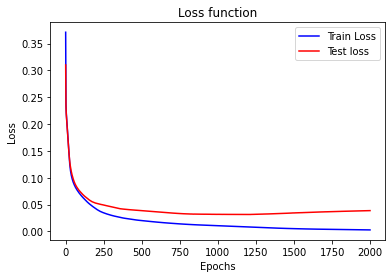

In [21]:
plt.figure()
plt.plot(train_loss_list_p1, color='b', label='Train Loss')
plt.plot(test_loss_list_p1, color='r', label='Test loss')
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

## Batch size 1

### Advertencia - Si se busca replicar estas celdas se recomienda bajar el número de épocas. La dejé en 2000 por consistencia sin embargo demora aproximadamente 9 minutos este experimento.

In [22]:
#Pytorch has a nice feature to prepare data. The DataLoader creates an iterator of batches which are very convenient for training
#Set the batch size the biggest value as possible depending on your GPU. Operations in a batch are parallelized.
BATCH_SIZE = 1

train_iterator_s1 = data.DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
valid_iterator_s1 = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator_s1 = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [23]:
# Create the model
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

#Create the object for the optimization. 
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
#criterion = nn.BCELoss()

#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

#Let's perform the training

EPOCHS = 2000

best_valid_loss = float('inf')

train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator_s1, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator_s1, criterion, device)
  test_loss, test_acc = evaluate(model, test_iterator_s1, criterion, device)

  train_loss_list.append(float(train_loss))
  test_loss_list.append(float(test_loss))
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  sys.stdout.write('\rEpoch {}, Train loss: {:.3f} | Train acc: {:.2f}% -- Val. Loss: {:.3f} | Val. Acc: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))
  #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch 1999, Train loss: 0.000 | Train acc: 100.00% -- Val. Loss: 0.024 | Val. Acc: 97.62%

In [24]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator_s1, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.043 | Test Acc: 96.15%


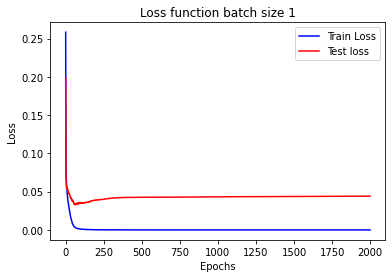

In [25]:
plt.figure()
plt.plot(train_loss_list, color='b', label='Train Loss')
plt.plot(test_loss_list, color='r', label='Test loss')
plt.title('Loss function batch size 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

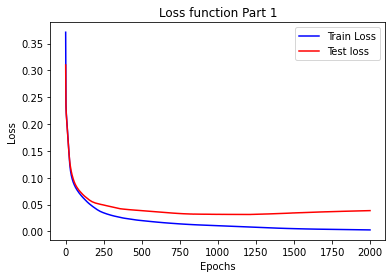

In [26]:
plt.figure()
plt.plot(train_loss_list_p1, color='b', label='Train Loss')
plt.plot(test_loss_list_p1, color='r', label='Test loss')
plt.title('Loss function Part 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Cuando entrenamos la red con un batch size igual a 1 significa que que por cada batch tenemos una muestra. Con esto la red está optimizando con este único valor por cada batch y por cada época, por lo que el tiempo de entrenamiento aumenta en relación con la parte 1. Considerando el tiempo de ejecución, esta opción conviene usarla cuando el input de entrada es muy grande pues procesar una muestra ya lleva mucho tiempo, así con un batch size de 1, es posible entrenar la red de una forma más controlable. A pesar de del tiempo de ejecución la red aprende de todas maneras.

En cuanto a los gráficos es posible notar que son bastante similares pues la función de loss se encuentra en un rango de la misma magnitud.

## Batch size 415

In [27]:
#Pytorch has a nice feature to prepare data. The DataLoader creates an iterator of batches which are very convenient for training
#Set the batch size the biggest value as possible depending on your GPU. Operations in a batch are parallelized.
BATCH_SIZE = 415

train_iterator_s415 = data.DataLoader(train_data, shuffle=False, batch_size=BATCH_SIZE)
valid_iterator_s415 = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator_s415 = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [28]:
# Create the model
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

#Create the object for the optimization. 
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
#criterion = nn.BCELoss()

#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

#Let's perform the training

EPOCHS = 2000

best_valid_loss = float('inf')

train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator_s415, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator_s415, criterion, device)
  test_loss, test_acc = evaluate(model, test_iterator_s415, criterion, device)

  train_loss_list.append(float(train_loss))
  test_loss_list.append(float(test_loss))
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  sys.stdout.write('\rEpoch {}, Train loss: {:.3f} | Train acc: {:.2f}% -- Val. Loss: {:.3f} | Val. Acc: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))
  #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch 1999, Train loss: 0.067 | Train acc: 93.30% -- Val. Loss: 0.075 | Val. Acc: 88.10%

In [29]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator_s415, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.075 | Test Acc: 91.35%


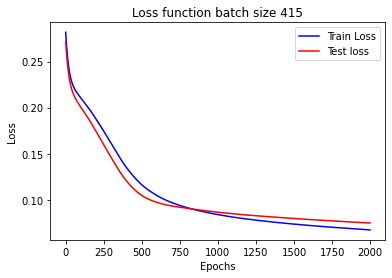

In [30]:
plt.figure()
plt.plot(train_loss_list, color='b', label='Train Loss')
plt.plot(test_loss_list, color='r', label='Test loss')
plt.title('Loss function batch size 415')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

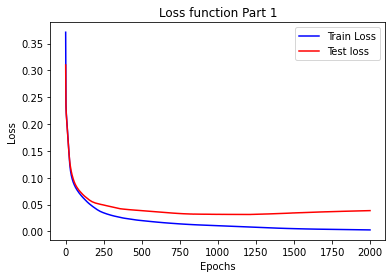

In [31]:
plt.figure()
plt.plot(train_loss_list_p1, color='b', label='Train Loss')
plt.plot(test_loss_list_p1, color='r', label='Test loss')
plt.title('Loss function Part 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Cuando utilizamos el batch size de 415 es como si estuvieramos optimizando con Gradiente Descendiente pues estamos considerando todos los inputs en un mismo batch y se realiza la optimización con todas las muestras, ademas al considerar un batch con una mayor cantidad de muestras, es posible que cueste un poco más encontrar mínimos locales pues se toman en consideración más datos y se estarían dando "pasos más grandes". Esta opción puede ser costosa computacionalmente por lo que no es preferible, en este experimento no existen mayores problemas pues no son tantas muestras. Es así como es preferible utilizar un batch size bastante más pequeño.

Si comporamos el entrenamiento con la parte anterior con un batch size de 1, el tiempo de ejecución fue menor y la función de loss alcanzó valores similares, que es esperable porque estamos utilizando los mismos datos y deberían converger eventualmente al mismo valor. Respecto a la parte 1 también se obtuvieron los mismos resultados en un tiempo de ejecución menor.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

## Learning Rate 0.5

In [32]:
# Create the model
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

#Create the object for the optimization. 
optimizer = optim.SGD(model.parameters(), lr=0.5)

criterion = nn.MSELoss()
#criterion = nn.BCELoss()

#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

#Let's perform the training

EPOCHS = 2000

best_valid_loss = float('inf')

train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

  train_loss_list.append(float(train_loss))
  test_loss_list.append(float(test_loss))
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  sys.stdout.write('\rEpoch {}, Train loss: {:.3f} | Train acc: {:.2f}% -- Val. Loss: {:.3f} | Val. Acc: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))
  #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch 1999, Train loss: 0.006 | Train acc: 100.00% -- Val. Loss: 0.024 | Val. Acc: 98.33%

In [33]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.042 | Test Acc: 95.00%


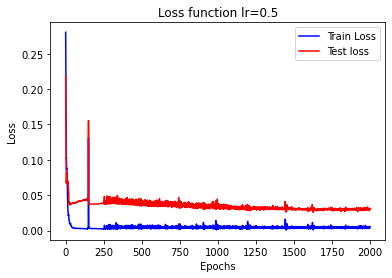

In [34]:
plt.figure()
plt.plot(train_loss_list, color='b', label='Train Loss')
plt.plot(test_loss_list, color='r', label='Test loss')
plt.title('Loss function lr=0.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

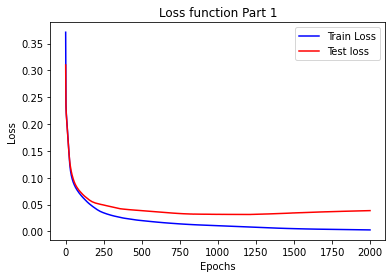

In [35]:
plt.figure()
plt.plot(train_loss_list_p1, color='b', label='Train Loss')
plt.plot(test_loss_list_p1, color='r', label='Test loss')
plt.title('Loss function Part 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

El learning rate es un parámetro que determina a grandes rasgos que tan rápido queremos que nuestra red varíe y actualice los parametros como los pesos y bias. A valores más grandes, como lr=0.5, se espera que la función de loss sea más ruidosa, es decir, va a existir una oscilación porque al momento de calcular los gradientes va a costar un poco más encontrar algún mínimo (local) frente a las variaciones de los pesos y bias en comparacion con la parte 1.

Es posible ver en el gráfico con lr=0.5 existe un comportamiento oscilante de la funcion loss debido a las razones mencionadas anteriormente.

## Learning rate 0.000001

In [36]:
# Create the model
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

#Create the object for the optimization. 
optimizer = optim.SGD(model.parameters(), lr=0.000001)

criterion = nn.MSELoss()
#criterion = nn.BCELoss()

#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

#Let's perform the training

EPOCHS = 2000

best_valid_loss = float('inf')

train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

  train_loss_list.append(float(train_loss))
  test_loss_list.append(float(test_loss))
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  sys.stdout.write('\rEpoch {}, Train loss: {:.3f} | Train acc: {:.2f}% -- Val. Loss: {:.3f} | Val. Acc: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))
  #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch 1999, Train loss: 0.318 | Train acc: 37.67% -- Val. Loss: 0.325 | Val. Acc: 31.67%

In [37]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.315 | Test Acc: 36.67%


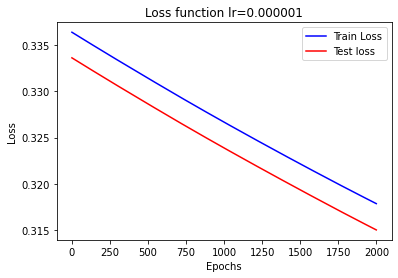

In [38]:
plt.figure()
plt.plot(train_loss_list, color='b', label='Train Loss')
plt.plot(test_loss_list, color='r', label='Test loss')
plt.title('Loss function lr=0.000001')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

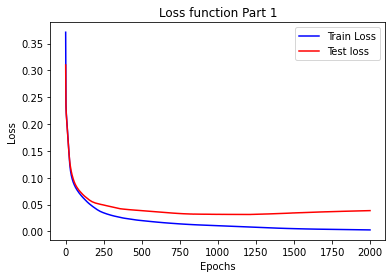

In [39]:
plt.figure()
plt.plot(train_loss_list_p1, color='b', label='Train Loss')
plt.plot(test_loss_list_p1, color='r', label='Test loss')
plt.title('Loss function Part 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Aquí el learning rate es muy bajo en comparación con la parte anterior y la parte 1, por lo que se espera que la red aprenda de forma muy lenta pues existen variaciones muy (en exceso) pequeñas respecto a los pesos y bias. Además, puede ocurrir que la red encuentre un mínimo local para la función de costo que no sea tan bueno, entonces ante variaciones tan pequeñas se puede quedar atrapada ahí.

En el gráfico con lr=0.000001 es posible ver que la red está aprendiendo pero a un paso muy lento, por lo que necesitaría más epocas pero no es la idea si es que podemos aumentar el learning rate.

Es importante mencionar que la red al termino de las 2 mil epocas aprendió muy poco y solo alcanzó un test accuracy de 36%.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [40]:
#Pytorch has a nice feature to prepare data. The DataLoader creates an iterator of batches which are very convenient for training
#Set the batch size the biggest value as possible depending on your GPU. Operations in a batch are parallelized.
BATCH_SIZE = 20

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [41]:
# Create the model
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

#Create the object for the optimization. 
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
#criterion = nn.BCELoss()

#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

#Let's perform the training

EPOCHS = 2000

best_valid_loss = float('inf')

train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

  train_loss_list.append(float(train_loss))
  test_loss_list.append(float(test_loss))
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  sys.stdout.write('\rEpoch {}, Train loss: {:.3f} | Train acc: {:.2f}% -- Val. Loss: {:.3f} | Val. Acc: {:.2f}%'.format(epoch, train_loss, train_acc*100, valid_loss, valid_acc*100))
  #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch 1999, Train loss: 0.001 | Train acc: 100.00% -- Val. Loss: 0.021 | Val. Acc: 98.33%

In [42]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.062 | Test Acc: 94.17%


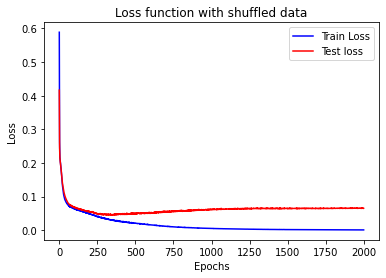

In [43]:
plt.figure()
plt.plot(train_loss_list, color='b', label='Train Loss')
plt.plot(test_loss_list, color='r', label='Test loss')
plt.title('Loss function with shuffled data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

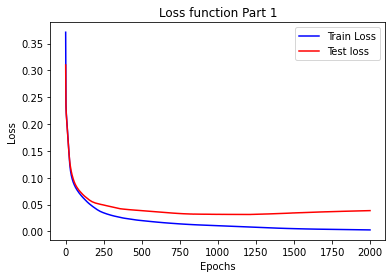

In [44]:
plt.figure()
plt.plot(train_loss_list_p1, color='b', label='Train Loss')
plt.plot(test_loss_list_p1, color='r', label='Test loss')
plt.title('Loss function Part 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Al revolver la data antes de las épocas de forma aleatoria reducimos las probabilidades de que en algún batch nos queden muestras que no ayuden a minimizar la función de costo. Así, es posible esperar que en cada batch tengamos muestras heterogéneas que permita a la red minimizar la función de costos.

Si comparamos los resultados obtenidos con la parte 1 vemos que la red converge a un rango del mismo valor.